In [1]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)

from smt.problems import WingWeight
from smt.sampling_methods import LHS

from sklearn.metrics import mean_squared_error

from smt.applications.explainability_tools import (
    PartialDependenceDisplay, 
    PDFeatureImportanceDisplay, 
    PDFeatureInteractionDisplay,
    ShapFeatureImportanceDisplay,
    ShapDisplay,
)
from smt.surrogate_models import KRG


In [2]:
ndoe = 300 
fun = WingWeight()
sampling = LHS(xlimits=fun.xlimits, criterion='ese', random_state=1)
X = sampling(ndoe)
y = fun(X)

n_train = int(0.8 * ndoe)

X_tr, y_tr = X[:n_train, :], y[:n_train]
X_te, y_te = X[n_train:, :], y[n_train:]

## config
feature_names = [
    r'$S_{w}$', r'$W_{fw}$', r'$A$', r'$\Delta$', 
    r'$q$', r'$\lambda$', r'$t_{c}$', r'$N_{z}$', 
    r'$W_{dg}$', r'$W_{p}$',
]

class GroundTruthModel:
    def predict_values(self, X):
        return fun(X)
    
print("Ground truth model")
gtm = GroundTruthModel()
y_pred = gtm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

Ground truth model
RMSE: 0.0000
rRMSE: 0.0000


In [3]:
sm = KRG(
    theta0=[1e-2]*X_tr.shape[1],
    print_prediction = False
    )
sm.set_training_values(
    X_tr, 
    y_tr
    )

sm.train()

print("Surrogate model")
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 240
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  5.2989829
Surrogate model
RMSE: 0.1650
rRMSE: 0.0006


# PD

## Basic functionalities

## Feature importance

In [6]:
model = sm
x = X_tr
pdd_importance = PDFeatureImportanceDisplay.from_surrogate_model(model, x, feature_names=feature_names)

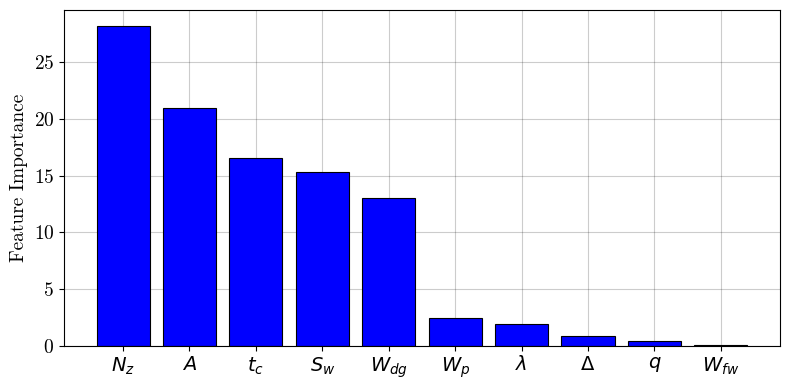

In [7]:
pdd_importance_fig = pdd_importance.plot(sort=True, figsize=[8, 4])
pdd_importance_fig

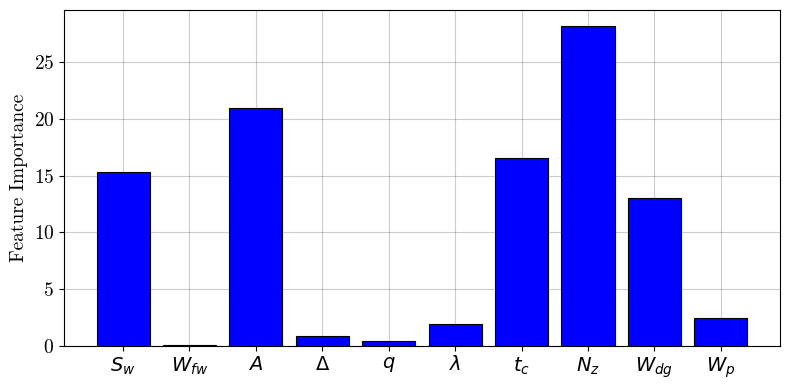

In [8]:
pdd_importance_fig = pdd_importance.plot(sort=False, figsize=[8, 4])
pdd_importance_fig

In [9]:
# model = gtm
# x = X_tr
# features = [0, 2]
# pdd_importance = PDFeatureImportanceDisplay.from_surrogate_model(model, x, features=features, feature_names=feature_names)
# pdd_importance.plot()

In [10]:
# pdd_importance.plot(sort=True)

In [11]:
# model = gtm
# x = X_tr
# features = [2, 0]
# pdd_importance = PDFeatureImportanceDisplay.from_surrogate_model(model, x, features=features, feature_names=feature_names)
# pdd_importance.plot()

CPU times: user 19.7 s, sys: 21.7 s, total: 41.5 s
Wall time: 5.99 s


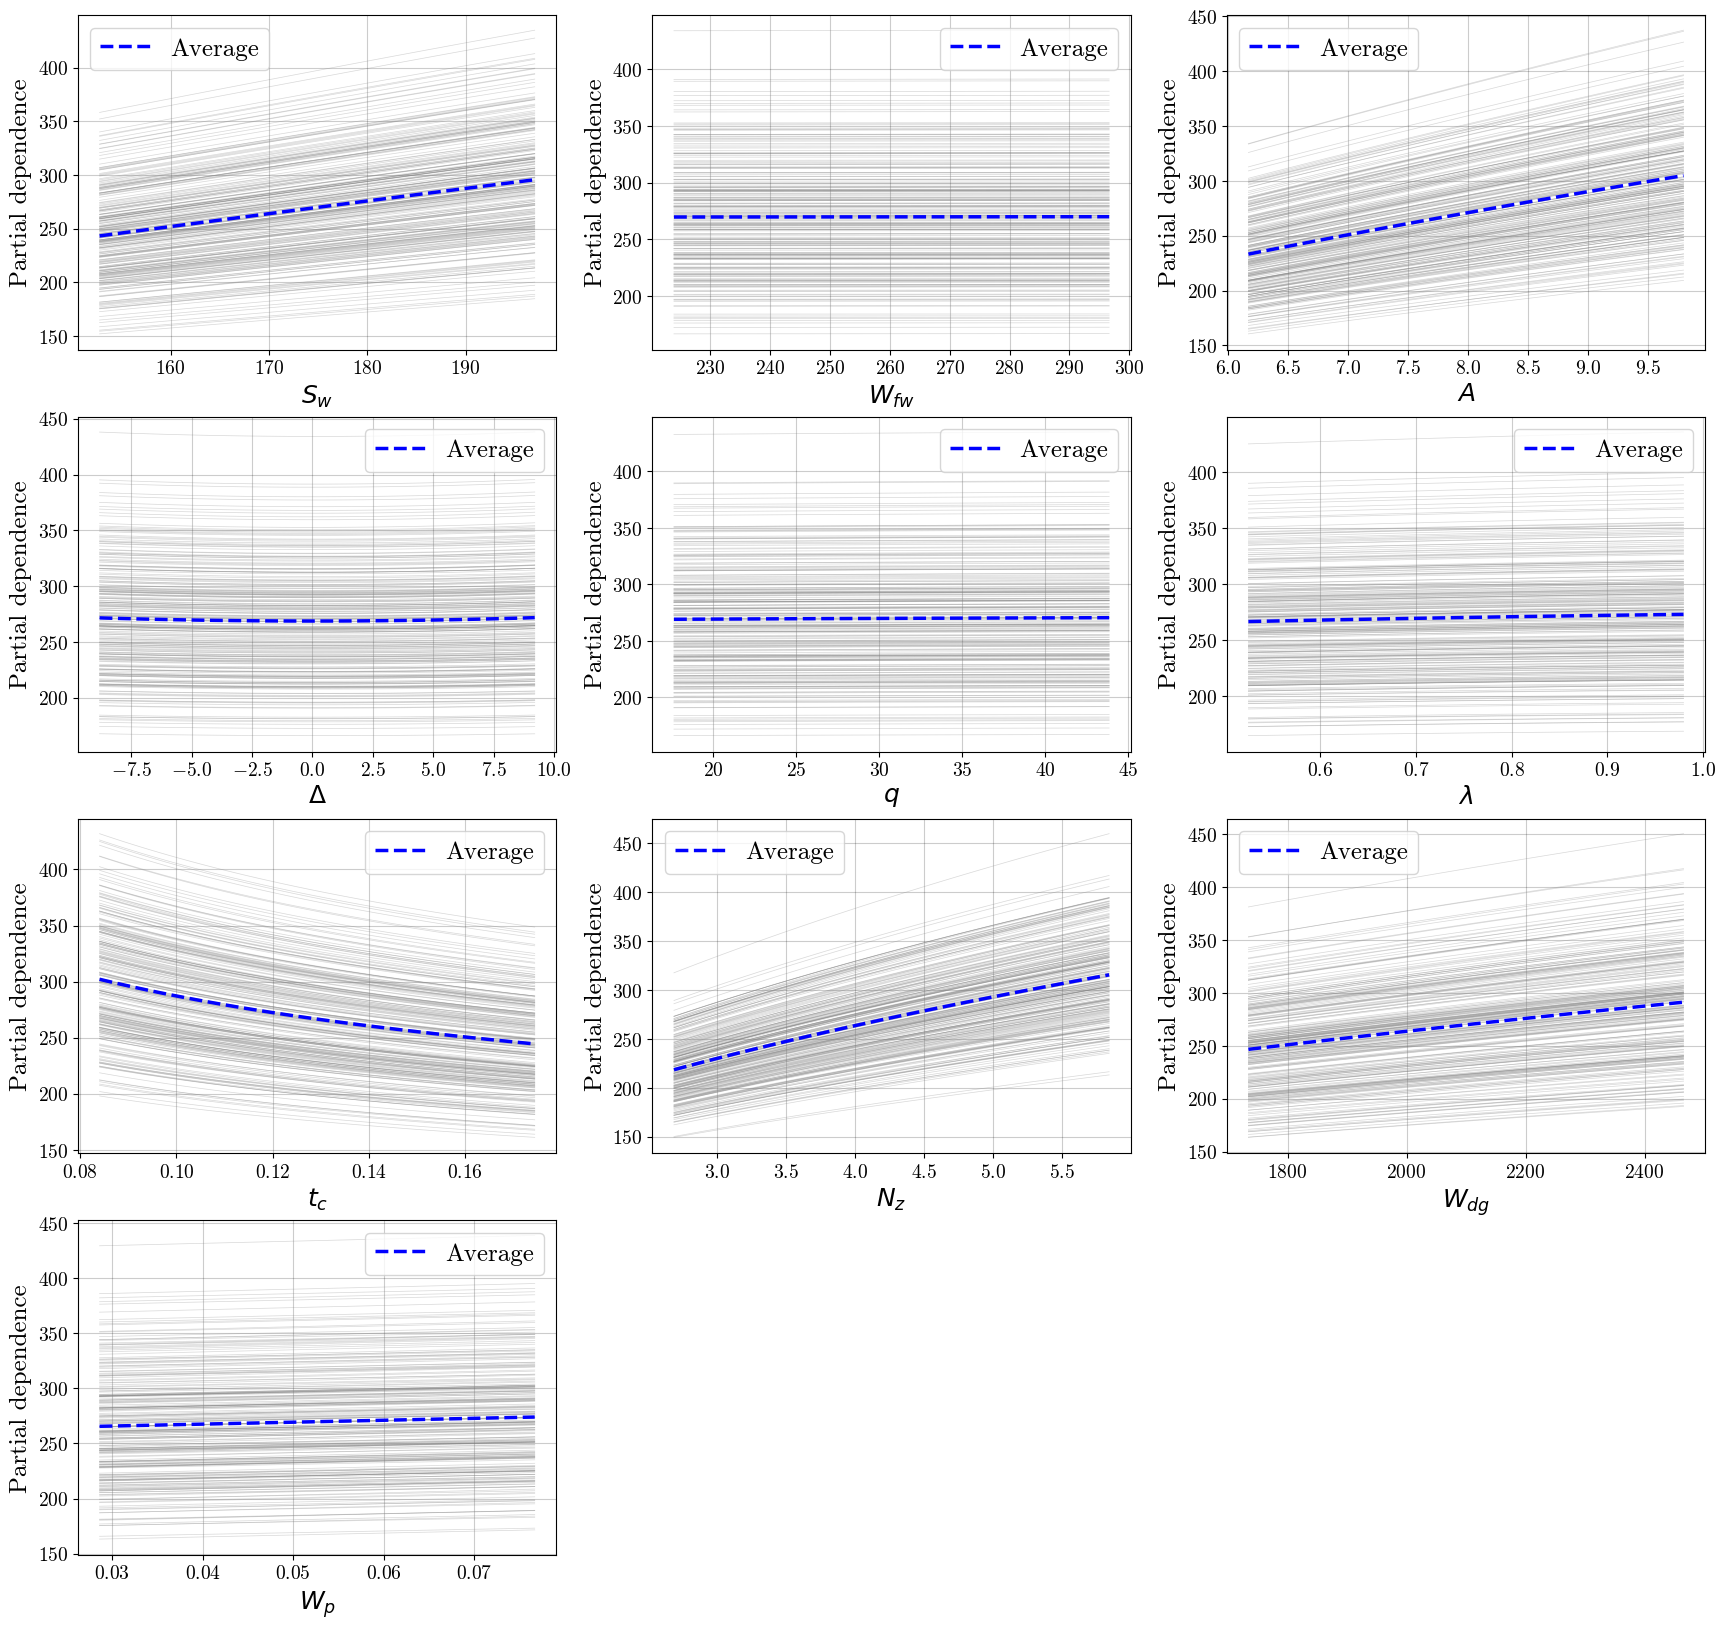

In [12]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    grid_resolution=100, 
    kind='both',
    feature_names=feature_names,
)
pdd_fig_1 = pdd.plot()
pdd_fig_1

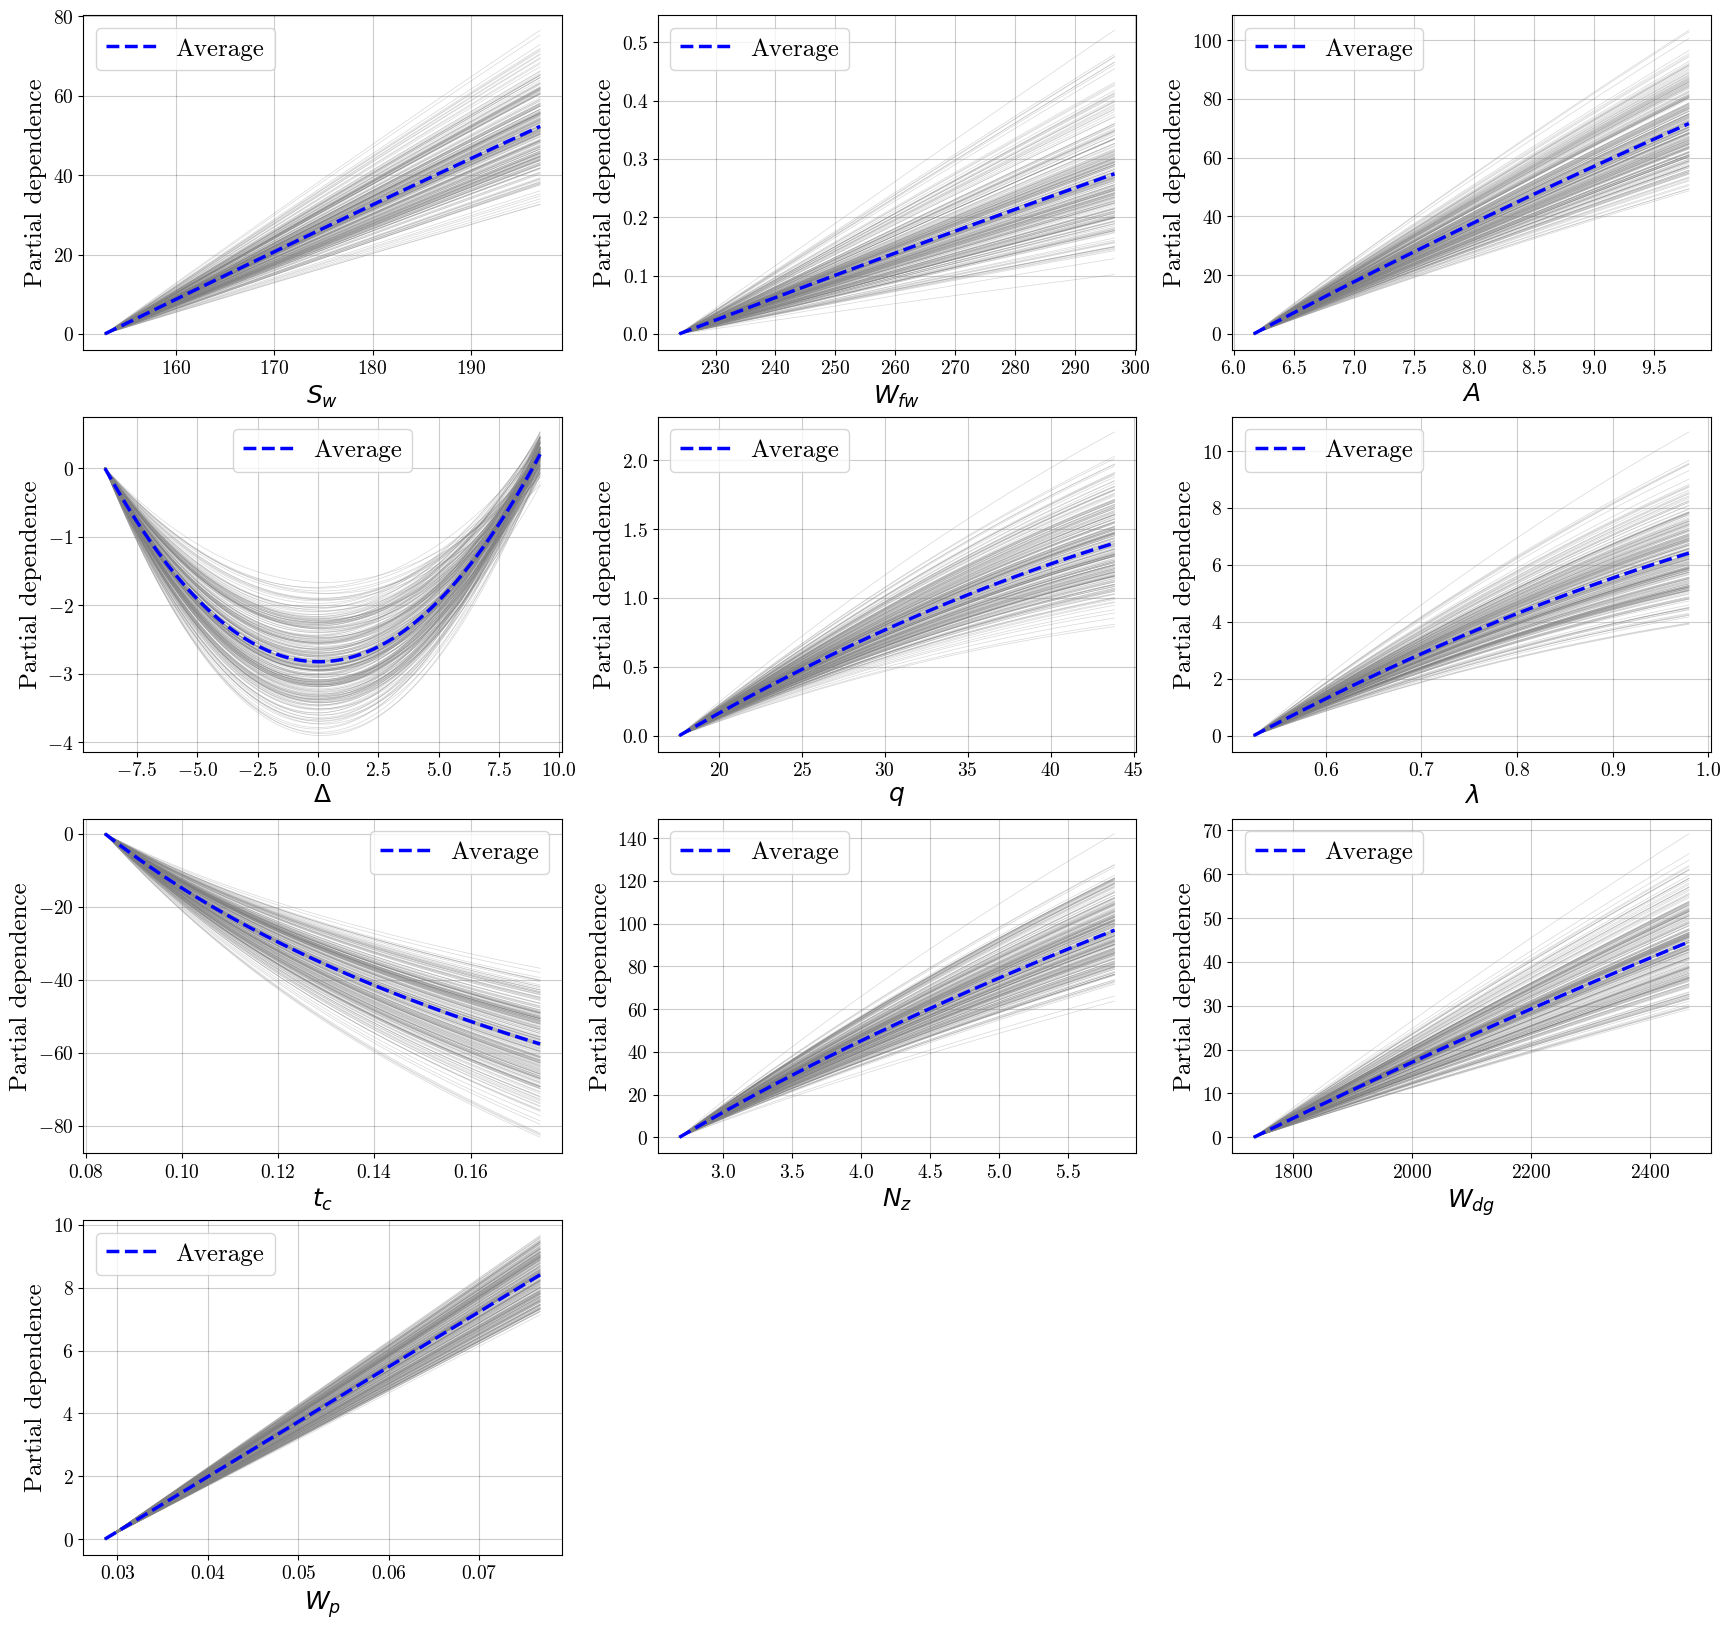

In [15]:
pdd.plot(centered=True)

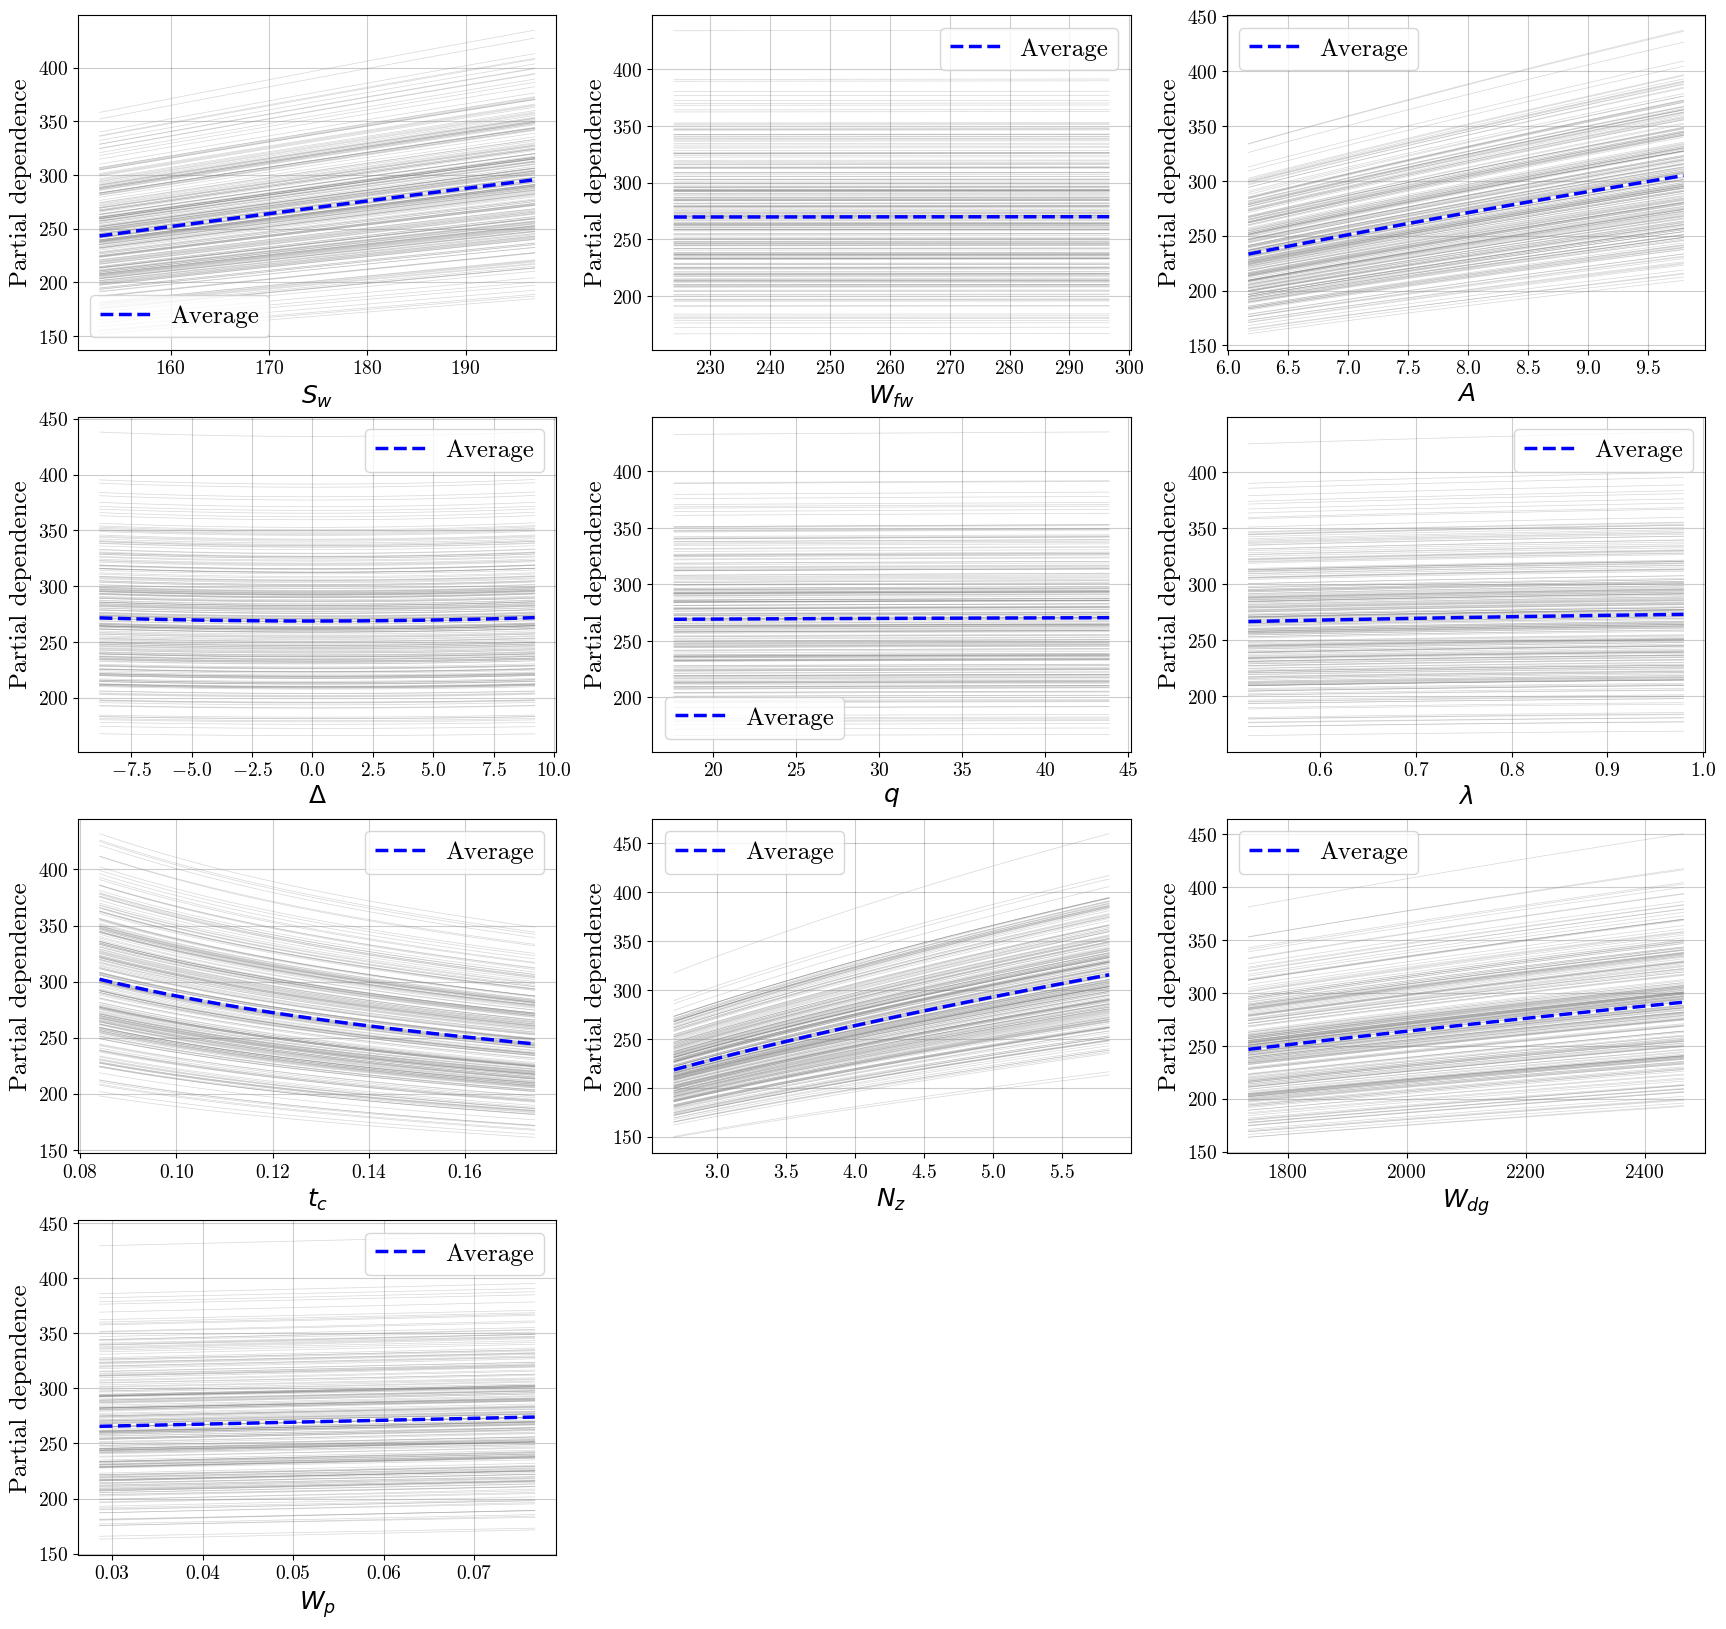

In [13]:
pdd.plot(legend_locations={0: "lower left", 4: "lower left"})

CPU times: user 3min 48s, sys: 2min 37s, total: 6min 25s
Wall time: 52 s


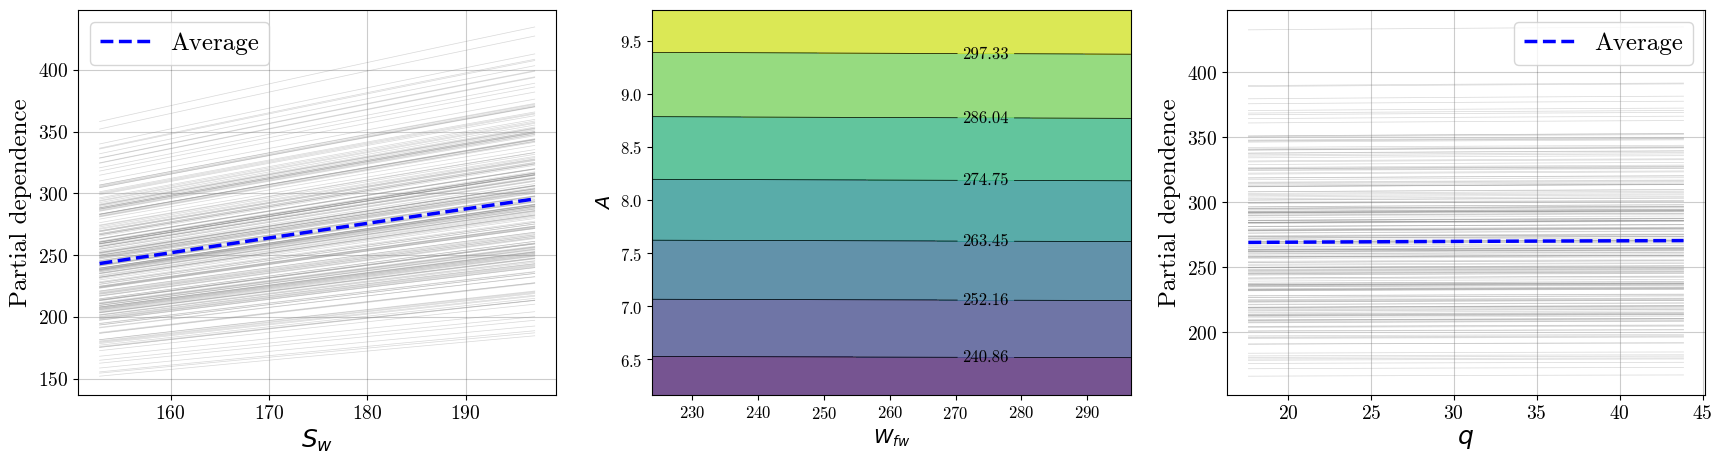

In [16]:
%%time
model = sm
X = X_tr
features = [0, (1, 2), 4]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    grid_resolution=100, 
    kind='both',
    feature_names=feature_names,
)
pdd_fig_2 = pdd.plot()
pdd_fig_2

# Shap

## Feature Importance

In [4]:
model = sm
x = X_tr
shap_importance = ShapFeatureImportanceDisplay.from_surrogate_model(model, x, feature_names=feature_names)

In [5]:
shap_importance.feature_importances

array([14.59209696,  0.12486877, 19.56959564,  1.26895882,  0.39661922,
        1.78360117, 15.75642623, 26.43624371, 12.33853966,  2.34913161])

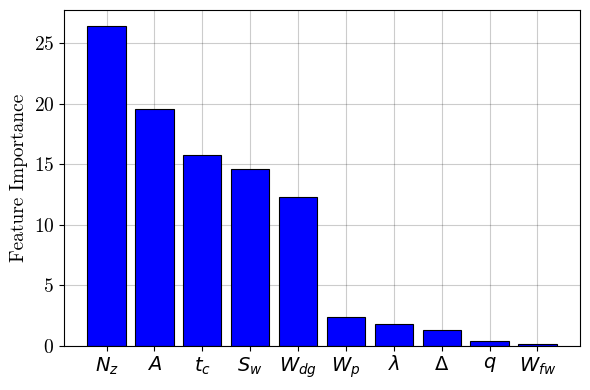

In [11]:
fig = shap_importance.plot(sort=True)
fig

In [21]:
# shap_importance = ShapFeatureImportanceDisplay.from_surrogate_model(model, x, features=[0, 2], feature_names=feature_names)

In [22]:
# shap_importance.plot(sort=False)

# Plots

In [12]:
%%time
instances = X_tr
model = sm
X = X_tr
explainer_train = ShapDisplay.from_surrogate_model(
    instances, 
    model, 
    X, 
    feature_names=feature_names,
)

CPU times: user 1min 4s, sys: 1min 50s, total: 2min 54s
Wall time: 25.9 s


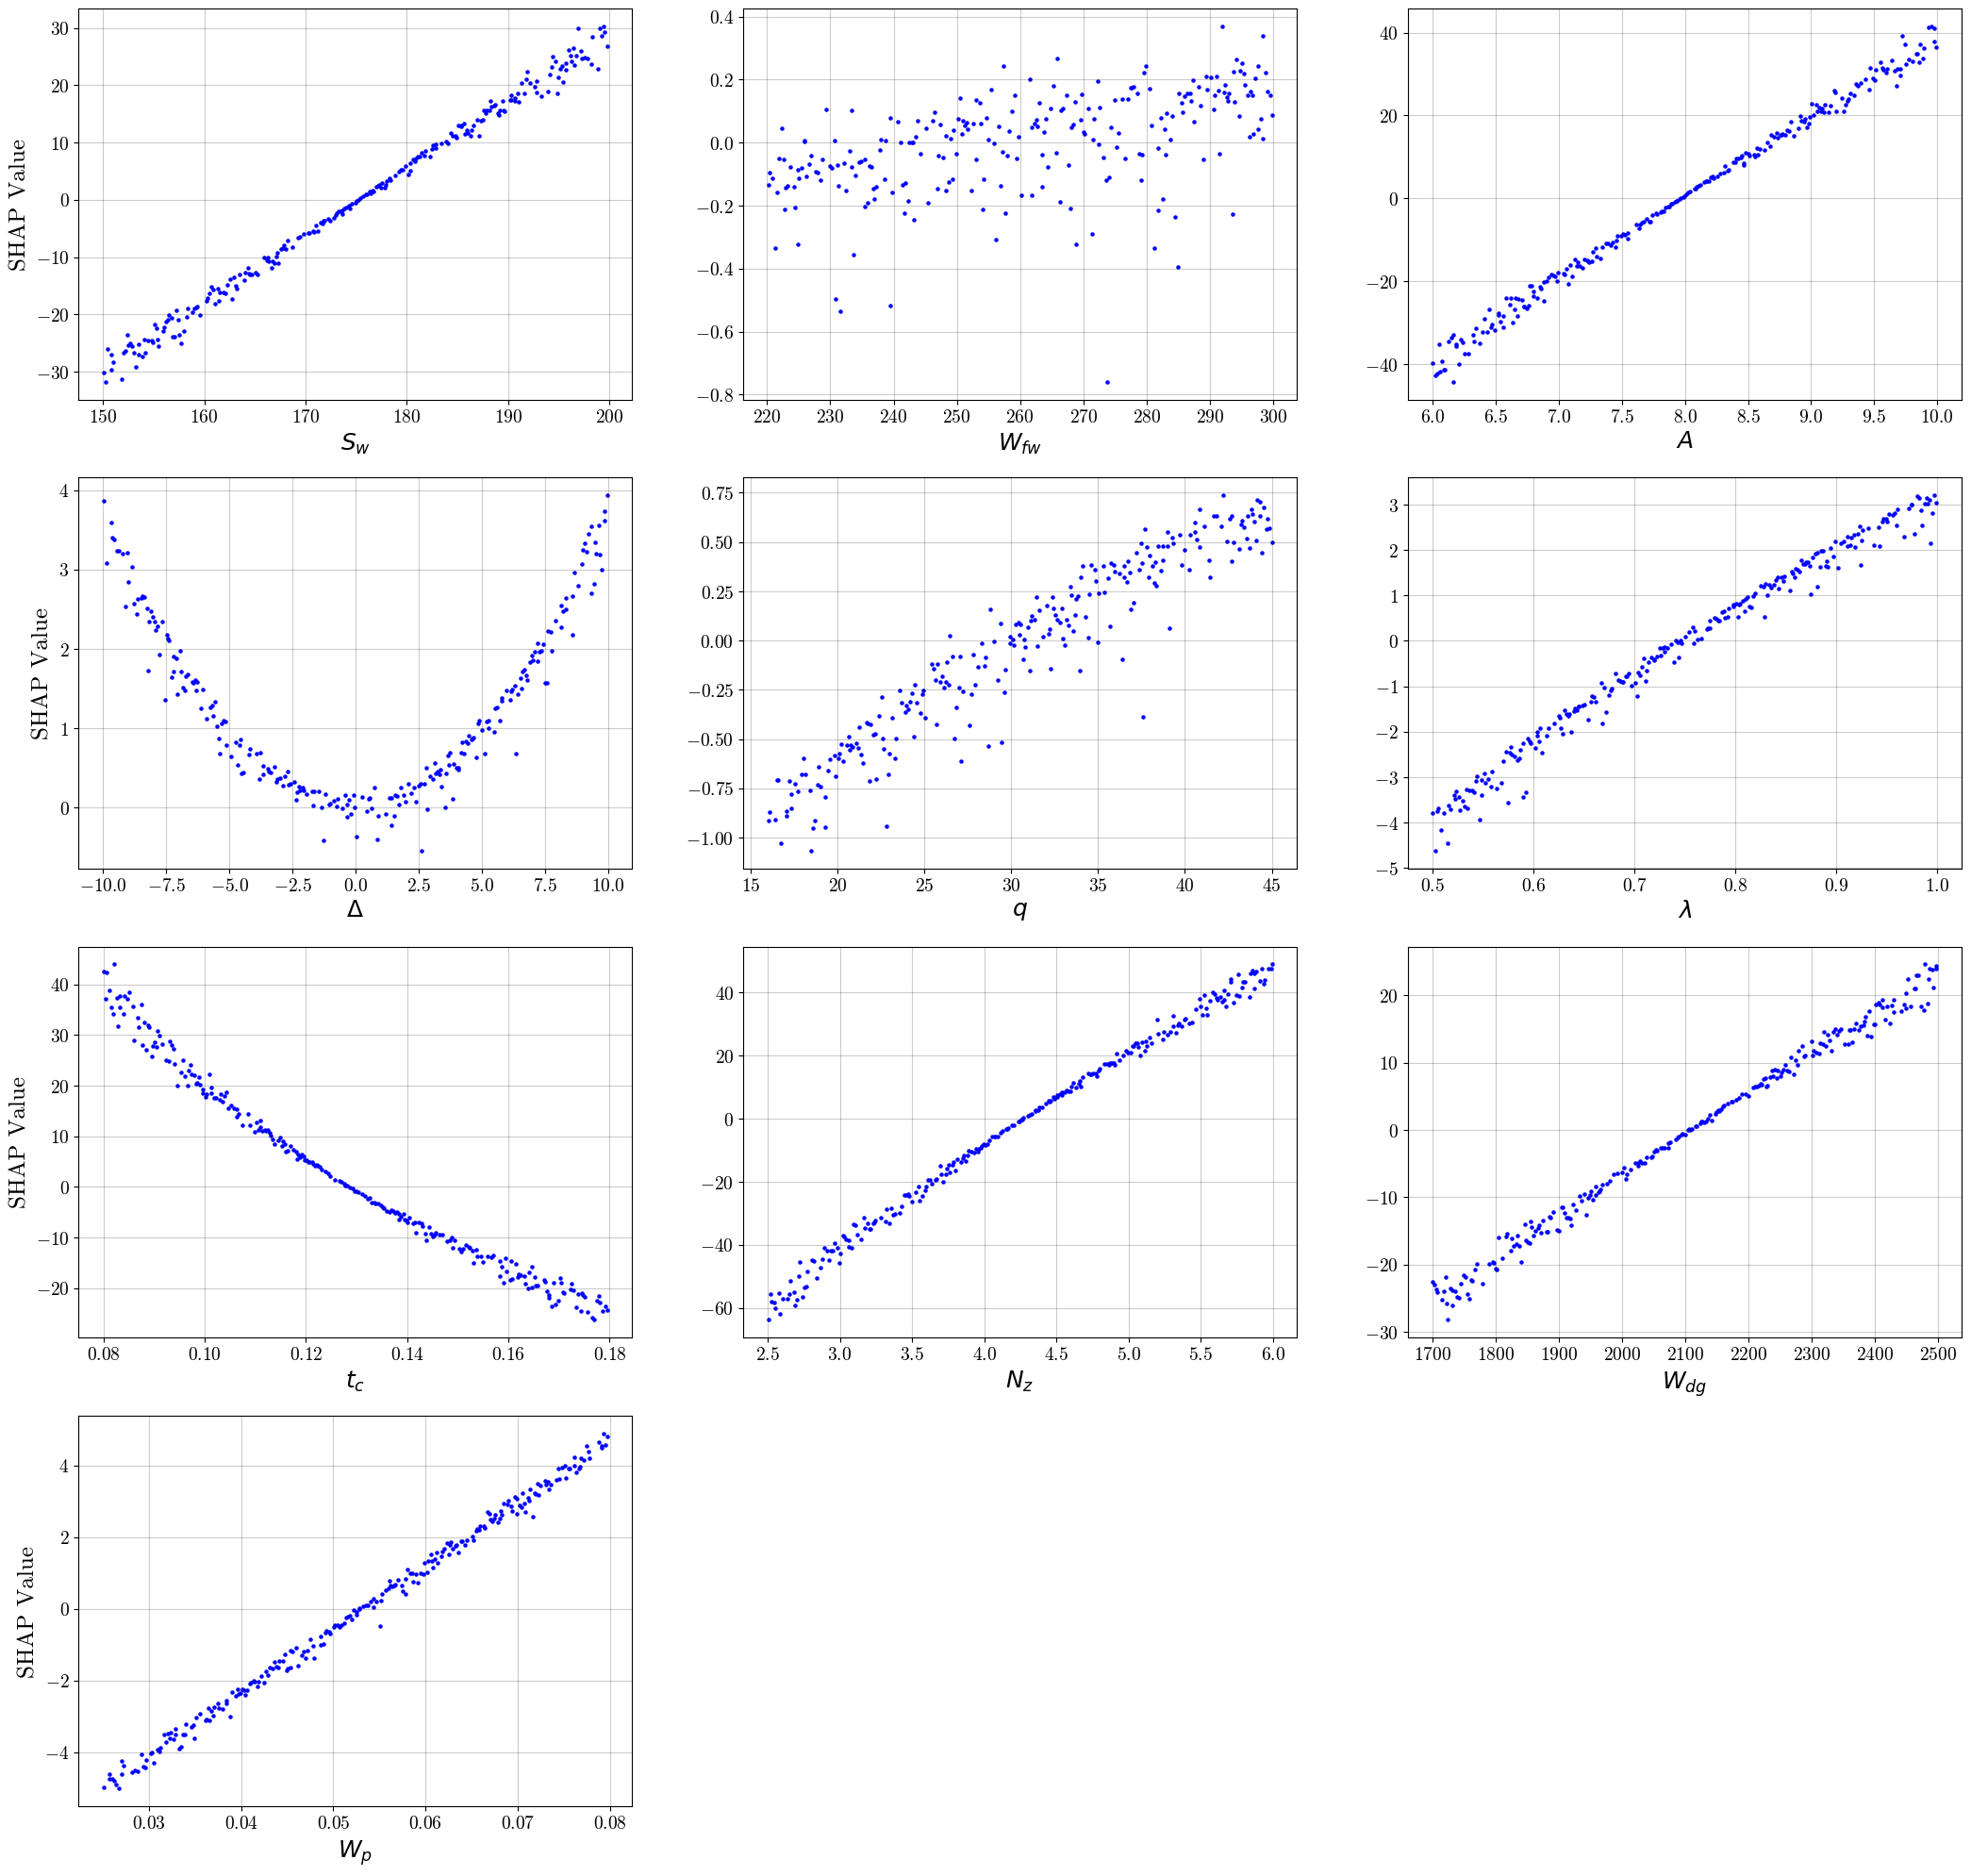

In [14]:
features = [i for i in range(X_tr.shape[1])]

fig = explainer_train.dependence_plot(features)
fig

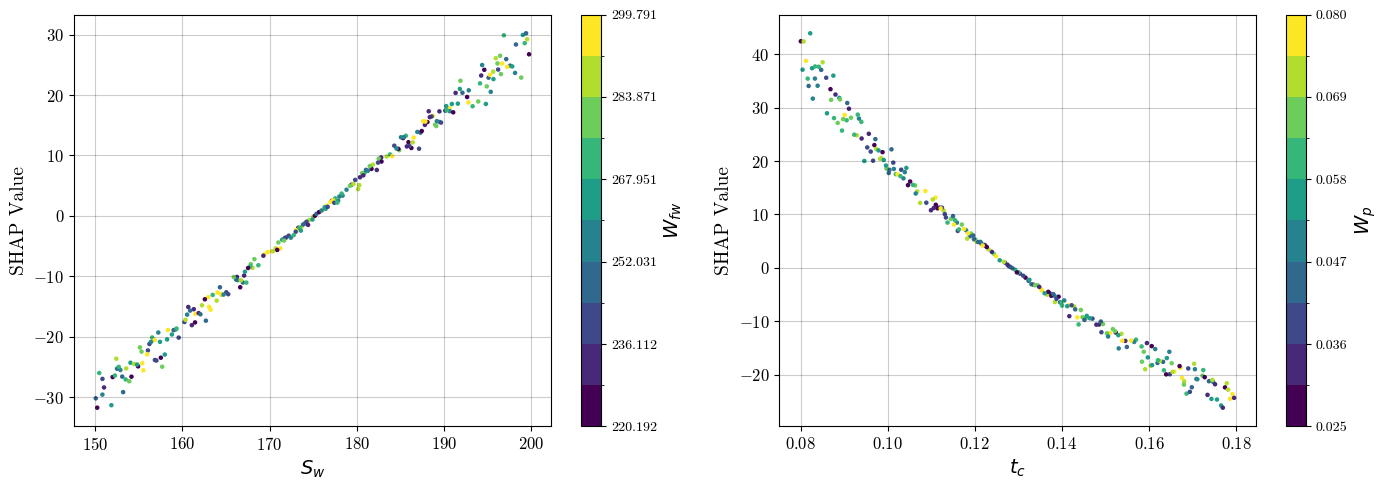

In [15]:
feature_pairs = [(0, 1), (6, 9)]

fig = explainer_train.interaction_plot(feature_pairs)
fig

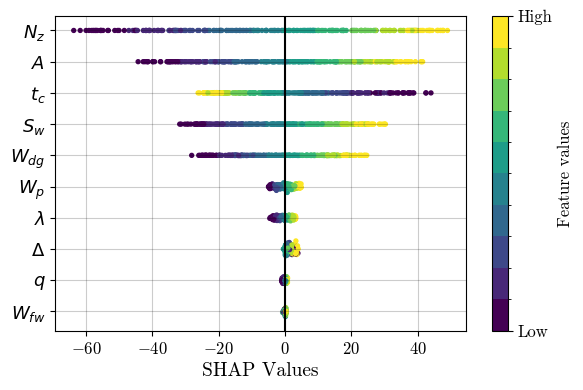

In [16]:
fig = explainer_train.summary_plot()
fig

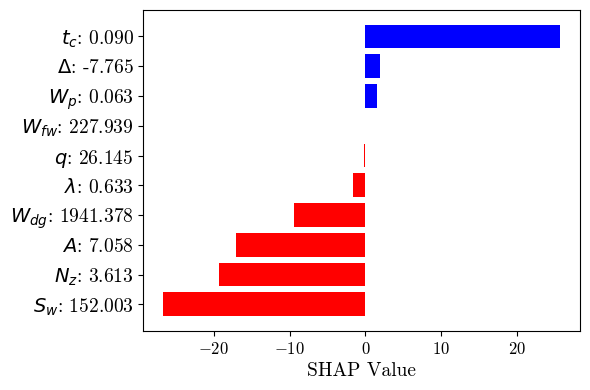

In [22]:
fig = explainer_train.individual_plot(index=10)
fig